In [1]:
import pandas as pd
import numpy as np

import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import warnings

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Crema = "/content/drive/MyDrive/python/Crema/"

In [4]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0    happy  /content/drive/MyDrive/python/Crema/1081_IEO_H...
1    happy  /content/drive/MyDrive/python/Crema/1080_TAI_H...
2    happy  /content/drive/MyDrive/python/Crema/1080_IEO_H...
3     fear  /content/drive/MyDrive/python/Crema/1080_MTI_F...
4    happy  /content/drive/MyDrive/python/Crema/1079_IOM_H...

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


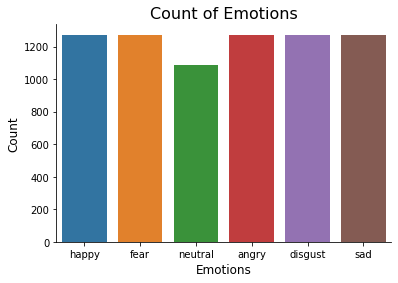

In [5]:
plt.title('Count of Emotions', size=16)
sns.countplot(Crema_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [6]:
audio_arrays = []

for i in Crema_df['Path']:
    x, sr = librosa.load(i, sr=44100)
    audio_arrays.append(x)
    
Crema_df['Audio'] = audio_arrays

In [14]:
Crema_df

Emotions  ...                                              Audio
0       happy  ...  [-0.0035415543, -0.0039250627, -0.0036865878, ...
1       happy  ...  [-0.0014183886, -0.0017157698, -0.0018661163, ...
2       happy  ...  [-0.0067417375, -0.007959854, -0.008086735, -0...
3        fear  ...  [0.00016061743, 5.778243e-05, -0.00012582871, ...
4       happy  ...  [-0.0014909565, -0.0018831126, -0.0022537203, ...
...       ...  ...                                                ...
7447  neutral  ...  [-0.0065709385, -0.0074430634, -0.007000865, -...
7448  neutral  ...  [-0.0057944655, -0.006189974, -0.005478489, -0...
7449  neutral  ...  [9.163477e-05, -5.3950764e-05, -0.00021171814,...
7450    angry  ...  [-0.0005702933, -0.00054082205, -0.0005001719,...
7451     fear  ...  [0.007085612, 0.008201618, 0.008001935, 0.0071...

[7452 rows x 3 columns]

In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

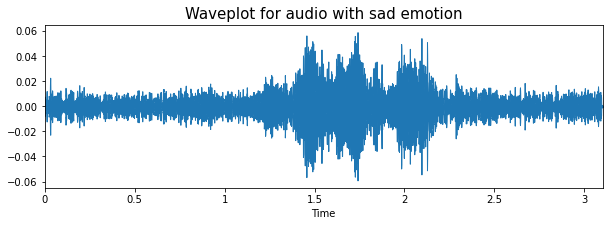

(68424,)


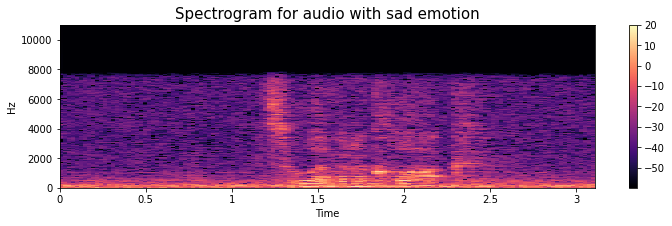

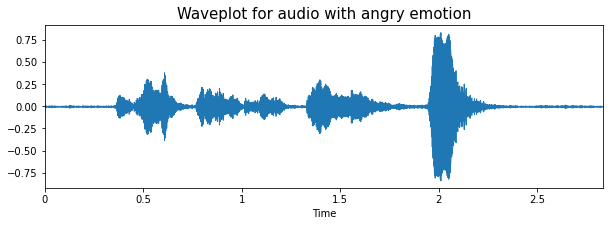

(62538,)


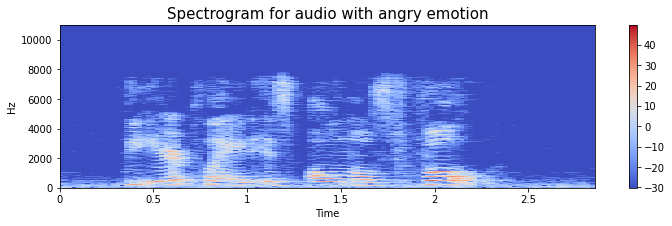

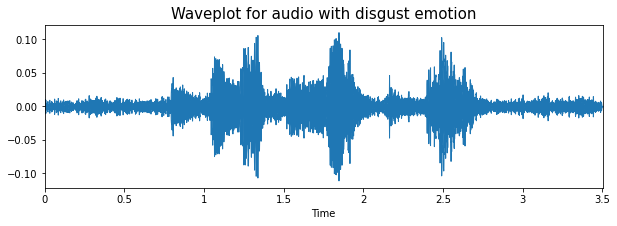

(77253,)


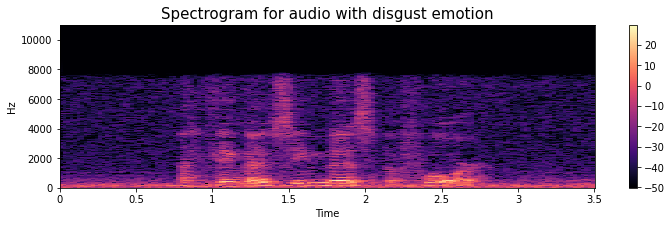

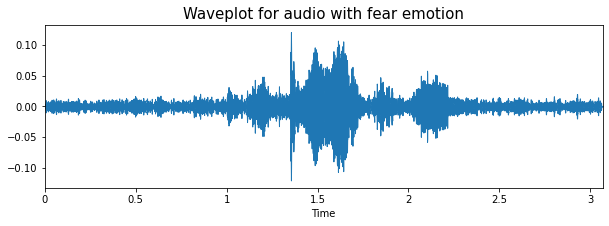

(67688,)


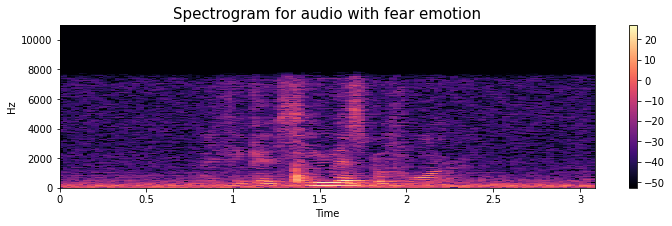

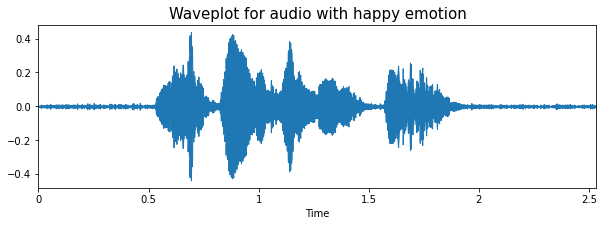

(55917,)


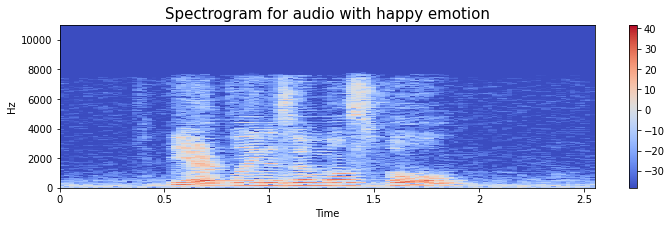

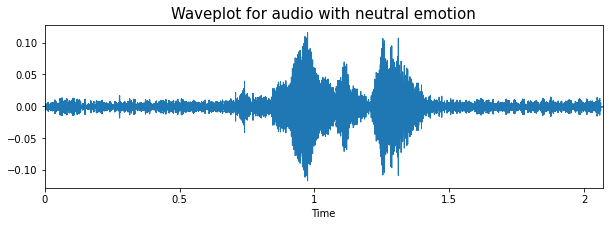

(45616,)


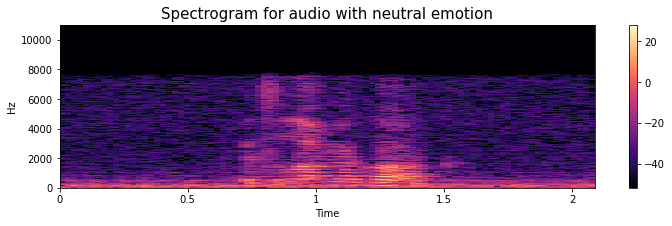

In [9]:
emotions = ['sad', 'angry', 'disgust', 'fear', 'happy', 'neutral']
for emotion in emotions:
    path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[1]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    display(Audio(path))
    print(data.shape)

In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [11]:
def extract_features(data):
    # Zero Crossing Rate
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, chroma_stft))     

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, mfcc))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, mel))
    
    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sr).T, axis=0);
    result = np.hstack((result, tonnetz));
    
    return result

In [12]:
def get_features(data):
    result = []
    
    # without augmentation
    res1 = extract_features(data)
    result.append(res1)
    
    # with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result.append(res2)
    
    # with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sr)
    res3 = extract_features(data_stretch_pitch)
    result.append(res3)
    
    return result

In [13]:
x = []
y = []
for i in range(len(Crema_df)):
    feature=get_features(Crema_df['Audio'].iloc[i]);
    for j in feature:
        x.append(j)
        y.append(Crema_df['Emotions'].iloc[i])

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=943
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=943
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency 

In [16]:
x

[array([ 4.98564122e-02,  6.07084215e-01,  6.43976271e-01,  6.00171089e-01,
         5.43968320e-01,  5.39496958e-01,  5.82972407e-01,  5.76797485e-01,
         5.96628547e-01,  6.72923088e-01,  7.45819151e-01,  6.99061394e-01,
         6.47323728e-01, -6.41665649e+02,  3.25214081e+01, -5.37825508e+01,
         2.06005726e+01,  1.00412025e+01, -2.03580723e+01, -1.02008021e+00,
        -7.75432301e+00, -5.93274355e+00, -6.27501106e+00, -1.18921318e+01,
         3.02613449e+00, -5.07758522e+00, -1.10265579e+01,  7.37470031e-01,
        -5.96908951e+00, -7.01206541e+00, -4.73560810e+00, -6.42665958e+00,
         9.67319608e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.35406807e-01,
         1.70812551e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  4.94340688e-01,  1.42724216e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.0

In [17]:
y

['happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'fear',
 'fear',
 'fear',
 'happy',
 'happy',
 'happy',
 'neutral',
 'neutral',
 'neutral',
 'angry',
 'angry',
 'angry',
 'fear',
 'fear',
 'fear',
 'disgust',
 'disgust',
 'disgust',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'sad',
 'sad',
 'sad',
 'happy',
 'happy',
 'happy',
 'neutral',
 'neutral',
 'neutral',
 'fear',
 'fear',
 'fear',
 'neutral',
 'neutral',
 'neutral',
 'fear',
 'fear',
 'fear',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'neutral',
 'neutral',
 'neutral',
 'fear',
 'fear',
 'fear',
 'happy',
 'happy',
 'happy',
 'angry',
 'angry',
 'angry',
 'sad',
 'sad',
 'sad',
 'happy',
 'happy',
 'happy',
 'fear',
 'fear',
 'fear',
 'angry',
 'angry',
 'angry',
 'happy',
 'happy',
 'happy',
 'angry',
 'angry',
 'angry',
 'fear',
 'fear',
 'fear',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutr

In [18]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(y))
y

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.1)

In [20]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)

In [21]:
x_train

array([[[ 0.03968667],
        [ 0.62851739],
        [ 0.61591154],
        ...,
        [ 0.01900451],
        [-0.00127988],
        [-0.02422394]],

       [[ 0.03272131],
        [ 0.665649  ],
        [ 0.66566503],
        ...,
        [-0.06970196],
        [ 0.00423083],
        [-0.01533153]],

       [[ 0.03636699],
        [ 0.72437429],
        [ 0.702636  ],
        ...,
        [-0.01955782],
        [-0.00130094],
        [ 0.0056439 ]],

       ...,

       [[ 0.22451696],
        [ 0.74527017],
        [ 0.81756783],
        ...,
        [ 0.01629226],
        [ 0.01033224],
        [ 0.01926709]],

       [[ 0.14166737],
        [ 0.8035696 ],
        [ 0.78399594],
        ...,
        [ 0.0041102 ],
        [ 0.01849165],
        [ 0.00930153]],

       [[ 0.02941856],
        [ 0.59089291],
        [ 0.61627746],
        ...,
        [-0.02719584],
        [ 0.00121099],
        [-0.0120301 ]]])

In [22]:
from keras import optimizers

In [23]:
model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D((1)))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(1024, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=0.0005),
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 165, 128)          512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 165, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 163, 256)          98560     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 163, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 161, 512)          393728    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 161, 512)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 159, 1024)         1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_test, y_test))

Epoch 1/50
158/158 [==============================] - 1246s 8s/step - loss: 3.8918 - accuracy: 0.2170 - val_loss: 1.5723 - val_accuracy: 0.3497
Epoch 2/50
158/158 [==============================] - 1220s 8s/step - loss: 1.5809 - accuracy: 0.3317 - val_loss: 1.4696 - val_accuracy: 0.3828
Epoch 3/50
158/158 [==============================] - 1226s 8s/step - loss: 1.5365 - accuracy: 0.3513 - val_loss: 1.5059 - val_accuracy: 0.3488
Epoch 4/50
158/158 [==============================] - 1239s 8s/step - loss: 1.4913 - accuracy: 0.3789 - val_loss: 1.4760 - val_accuracy: 0.3725
Epoch 5/50
158/158 [==============================] - 1227s 8s/step - loss: 1.4644 - accuracy: 0.4008 - val_loss: 1.4329 - val_accuracy: 0.3945
Epoch 6/50
158/158 [==============================] - 1237s 8s/step - loss: 1.4389 - accuracy: 0.4045 - val_loss: 1.4448 - val_accuracy: 0.3994
Epoch 7/50
158/158 [==============================] - 1233s 8s/step - loss: 1.4229 - accuracy: 0.4118 - val_loss: 1.4576 - val_accuracy:

In [ ]:
y_pred = model.predict(x_test)
print(y_pred)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'], yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])